# Text Mining Analysis of Yelp Reviews & Predicting a Review's Star Rating

## By Lauren Gripenstraw, Kendall Brown, Jory Oberlies, and Rahul Narula



In this project, our goal is to discover insights in customer reviews and predict a review's star rating through text mining and machine learning processes.

Necessary modules: (may need to be installed)

sklearn  
imblearn  
nltk  
contractions2 (from Prof. Oh's lecture)  
feature_extractors (from Prof. Oh's lecture)  
numpy  
matplotlib  
pandas  
seaborn  
string  
re

## Import Modules and Define Functions

In [1]:
'''Import necessary modules and functions'''


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Text Mining Modules
import re
import string
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from contractions2 import CONTRACTION_MAP
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from feature_extractors import tfidf_transformer
from feature_extractors import bow_extractor

## Machine Learning Modules
from sklearn import metrics
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE

## Additional imports and downloads
nltk.download(['stopwords', 'punkt', 
               'averaged_perceptron_tagger',
               'universal_tagset','wordnet'])

wnl = WordNetLemmatizer()

/Users/laurengripenstraw/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laurengripenstraw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/laurengripenstraw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/laurengripenstraw/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/laurengripenstraw/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/laurengripenstraw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We use a set of functions to accomplish the following:
    
    Expand contractions (e.g. I've -> I have')
    Concatenate 'not' and following word (e.g. not good -> notgood)
    Stem words (e.g. eating -> eat)
    Lemmatize words (e.g. worse -> bad)
    Remove special characters 
    Remove stop words (e.g. 'the')
    Convert all words to lower case
    
This is done through text normalization.

In [2]:
'''Define functions necessary to run text-mining methods
   Some directly from Professor Oh's lecture notes'''


def expand_contractions(text, contraction_mapping):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        # not sure why below is there
        expanded_contraction = first_char+expanded_contraction[1:] 
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def concat(corpus):
    corpus = list(map(lambda x: x.split(), corpus))
    for i in range(0, len(corpus)):
        for j in range(0, len(corpus[i])):
            if j != 0:
                x = corpus[i]
                if x[j-1] == "not":
                    x[j-1] = x[j-1] + x[j]
                    x[j] = ''
    corpus = list(map(lambda x: ' '.join(x), corpus))
    return corpus

## Tokenize text
def tokenize_text(text):
    tokens = nltk.word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens

## Remove special characters
def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

## Remove stopwords
def remove_stopwords(text,stopword_list):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

## Annotate text tokens with POS tags
def pos_tag_text(text):
    
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None

    tagged_text = pos_tag(text)
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_lower_text

TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that  increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.
We use this to account for the frequency of certain words in documents and the ratio of documents that include those words.

NMF (Non-negative Matrix Factorization) is a factorization method used to factor a matrix X into bases with non-negative values.
We use NMF to create a document term matrix.


In [3]:
'''Define functions necessary to run text-mining methods
   Some directly from Professor Oh's lecture notes'''


## Stem text
def lemmatize_text(text):
    text = tokenize_text(text)
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word                     
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

## Keep Text Characters
def keep_text_characters(text):
    filtered_tokens = []
    tokens = tokenize_text(text)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

## Normalize Text
def normalize_text(text,tokenize=True):
    text = lemmatize_text(text)
    text = remove_special_characters(text)
    text = remove_stopwords(text,ENGLISH_STOP_WORDS)
    text = keep_text_characters(text)
    return text

## Remove Numbers from Text
def remove_numbers(text):
    no_numbers = re.sub("\d+", " ", text)
    return(no_numbers)

## Term Frequency - Inverse Document Frequency
def tf_idf(corpus):
    # Bag of words construction
    bow_vectorizer, bow_features = bow_extractor(corpus=corpus)
    # feature names
    feature_names = bow_vectorizer.get_feature_names()
    # TF-IDF    
    tfidf_trans, tfidf_features = tfidf_transformer(bow_features)
    tfidf_features = np.round(tfidf_features.todense(),2)
    return((tfidf_features, feature_names))

## Non-Negative Matrix Factorization
def non_negative_marix_decomp(n_components,train_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, 
                     init='nndsvda', max_iter=500, 
                     random_state=0)
    W = model.fit_transform(train_data)
    H = model.components_
    nmf = (W,H)
    return(nmf)

In [4]:
## Read in data
reviews = pd.read_csv("yelp.csv")

## Create data corpus
review_corpus = reviews.iloc[:, 4]

## Preview Data
reviews.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [5]:
## Data preprocessing
review_corpus = [expand_contractions(review, CONTRACTION_MAP) for review in review_corpus]
for i in range(0, len(review_corpus)):
    review_corpus[i] = review_corpus[i].lower()

review_corpus = concat(review_corpus)
review_corpus = [normalize_text(review) for review in review_corpus]
review_corpus = [remove_numbers(review) for review in review_corpus]

In [6]:
reviews["stars"].value_counts()

4    3526
5    3337
3    1461
2     927
1     749
Name: stars, dtype: int64

A disproportionate amount of reviews in our sample are 4-star and 5-star reviews. This may indicate a propensity of reviewers to 
tend to submit more reviews for businesses they have had a significantly positive experience with.

In [7]:
np.random.seed(111)
samp = [0] * 4
for i in range(0, 4):
    samp[i] = reviews[reviews.stars == (i+2)].sample(749)
undersamp = reviews[reviews.stars == 1]
for i in range(0, 4):
    undersamp = undersamp.append(samp[i])
under_corpus = undersamp.iloc[:, 4]

We use the lowest number of reviews per star from the value_counts function above, which is 749 for 1-star ratings,
to sample randomly from the other star ratings to create an even, undersampled data set.

In [8]:
## Data preprocessing for undersampled set
under_corpus = [expand_contractions(review, CONTRACTION_MAP) for review in under_corpus]
for i in range(0, len(under_corpus)):
    under_corpus[i] = under_corpus[i].lower()

under_corpus = concat(under_corpus)

under_corpus = [normalize_text(review) for review in under_corpus]
under_corpus = [remove_numbers(review) for review in under_corpus]

## Exploratory Analysis

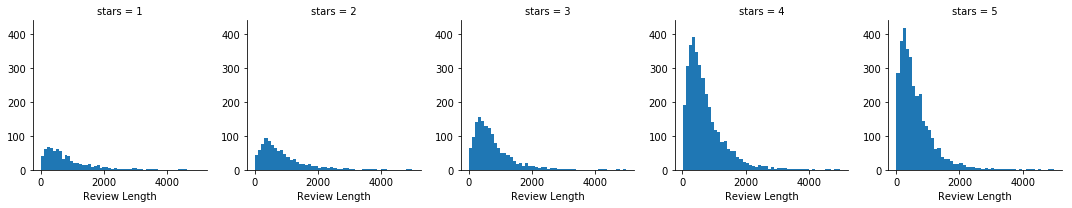

In [9]:
'''Exploratory Analysis of Text
   Text Length'''

## Add column to dataset containing review lengths (before pre-processing)
reviews['Review Length'] = reviews['text'].apply(len)

## Plot histogram of review length by star rating
%matplotlib inline
lenplot = sns.FacetGrid(data=reviews, col='stars')
lenplot.map(plt.hist, 'Review Length', bins=50)
plt.show()

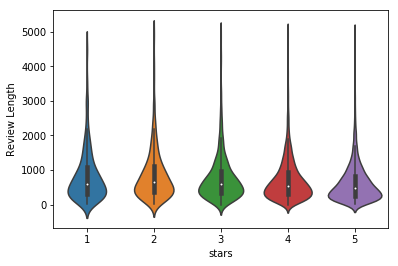

In [10]:
## Violin Plot of review length by rating

%matplotlib inline
sns.violinplot(x='stars', y='Review Length', data=reviews)
plt.show()

It appears that review length is similar across the board, with most reviewers opting for relatively shorter reviews.

## Text Mining

### Topic Modeling

In addition to NMF for Topic Modeling, we also use LDA (Latent Dirichlet allocation), 
a statistical model which allows sets of observations to be explained by unobserved groups 
that explain why certain sections of the data are similar.

In our use of LDA, this model assumes a document is a mixture of a small number of topics.


In [11]:
'''Topic modeling using NMF and LDA
   Use TF-IDF for NMF and word frequency for LDA'''

## Function to display topics
def display_topics(model, feature_names, no_top_words):
    for index, topic in enumerate(model.components_):
        print("Topic %d:" % (index))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

## How many top words to consider when topic modeling
no_features = 1000

## Use TF-IDF for NMF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(review_corpus)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

## LDA -- Use raw word counts
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(review_corpus)
tf_feature_names = tf_vectorizer.get_feature_names()

## Number of topics to use & number of top words to display for each topic
no_topics = 10
no_top_words = 10

## Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

## Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', 
                                learning_offset=50., random_state=0).fit(tf)

## Display topics
print("NMF Topics")
display_topics(nmf, tfidf_feature_names, no_top_words)
print("\n")
print("LDA Topics")
display_topics(lda, tf_feature_names, no_top_words)

/Users/laurengripenstraw/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


NMF Topics
Topic 0:
time like just place say make come really want know
Topic 1:
great service friendly staff food atmosphere place price awesome recommend
Topic 2:
chicken order salad sandwich sauce dish cheese lunch menu try
Topic 3:
pizza crust slice good wing salad best topping order cheese
Topic 4:
food good service place price mexican restaurant pretty really excellent
Topic 5:
burger fry sweet potato bun onion good cheese order bacon
Topic 6:
store price selection item buy shop grocery sale mall help
Topic 7:
bar beer drink night wine selection bartender music game place
Topic 8:
love place amaze delicious favorite amazing awesome kid super best
Topic 9:
sushi hour happy roll tuna price menu special chef fish


LDA Topics
Topic 0:
pizza good sandwich place breakfast love cheese order like try
Topic 1:
good place bar like burger beer drink pretty food really
Topic 2:
say just time like place ask tell come wait make
Topic 3:
place like make just store time love really new great
To

It can be observed that Topics 1 and 3-9 for NMF and 1, 3-5, 8, and 9 for LDA are more valuable because they more clearly 
reference a certain type of establishment. We can also see that NMF performed better because it gave us more valuable topics.

### Sentiment Analysis

We completed this section in R, because in our opinion its sentiment analysis packages are better. 

See other notebook for details.

## Machine Learning

In [12]:
'''Creating functions necessary for metrics'''

def print_metrics(preds):
    print('Accuracy: ', metrics.accuracy_score(y_test, preds))
    print('\n')
    print('Performance Metrics:', '\n', metrics.classification_report(y_test, preds))
    print('\n')
    print(' Confusion Matrix:', '\n', metrics.confusion_matrix(y_test, preds))
    
def plot_roc(preds):
    fpr = [0] * 5
    tpr = [0] * 5
    roc_auc = [0] * 5

    colors = ['turquoise', 'magenta', 'lime', 'indigo', 'orange']
    
    for i in range(0, 5):
        fpr[i], tpr[i], _ = roc_curve(y_test, preds[i], pos_label = (i+1))
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    for i in range (0, 5):
        stars = i + 1
        plt.plot(fpr[i], tpr[i],
             label=("{0} Star ROC curve (area = {1:0.2f})"
               ''.format(stars, roc_auc[i])),
             color = colors[i], linewidth = 4)
    plt.plot([0, 1], 'r--')
    plt.legend()
    plt.show()
    print("Average AUC = ", sum(roc_auc)/5)

### Undersampling

### Multinomial Naïve Bayes

In [13]:
tfidf_features,feature_names = tf_idf(under_corpus)
## Split into training/test
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, undersamp.iloc[:,3], random_state = 37)

nb = MultinomialNB()
fit = nb.fit(X_train, y_train)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.4279615795090715


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.58      0.66      0.62       184
          2       0.47      0.27      0.34       201
          3       0.31      0.47      0.37       181
          4       0.34      0.42      0.37       182
          5       0.58      0.34      0.43       189

avg / total       0.46      0.43      0.43       937



 Confusion Matrix: 
 [[121  32  26   5   0]
 [ 52  54  76  18   1]
 [ 16  21  85  49  10]
 [  8   4  57  76  37]
 [ 11   5  30  78  65]]


In [14]:
preds_prob = fit.predict_proba(X_test)
preds_u = [0] * 5
for i in range(0, 5):
    preds_u[i] = preds_prob[:, i]

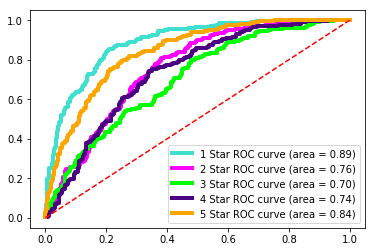

Average AUC =  0.7849155374682291


In [15]:
plot_roc(preds_u)

For the Multinomial Naïve Bayes method, the largest AUC is for 1-star reviews, followed closely by 5-star reviews. It seems
that these more extreme ratings correlate with more extreme language to describe theme, discerning them effectively from
2-star, 3-star, and 4-star reviews.

### Multinomial Logistic Regression

In [16]:
lg = LogisticRegression()
fit = lg.fit(X_train, y_train)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.46744930629669157


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.54      0.74      0.63       184
          2       0.52      0.30      0.38       201
          3       0.40      0.36      0.38       181
          4       0.36      0.35      0.35       182
          5       0.49      0.59      0.53       189

avg / total       0.46      0.47      0.45       937



 Confusion Matrix: 
 [[137  25  13   4   5]
 [ 73  61  42  18   7]
 [ 21  19  65  39  37]
 [ 14   5  31  63  69]
 [  9   7  11  50 112]]


In [17]:
preds_prob = fit.predict_proba(X_test)
preds_u = [0] * 5
for i in range(0, 5):
    preds_u[i] = preds_prob[:, i]

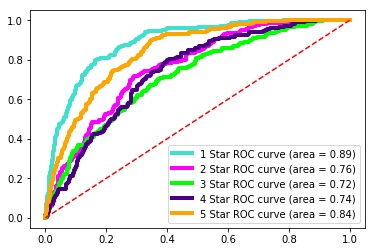

Average AUC =  0.7899064986138871


In [18]:
plot_roc(preds_u)

The Multinomial Logistic Regression method gives results similar to the Multinomial Naïve Bayes method.

### Random Forest

In [19]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 37)
fit = rf.fit(X_train, y_train)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.42902881536819637


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.50      0.65      0.57       184
          2       0.46      0.20      0.28       201
          3       0.35      0.43      0.38       181
          4       0.33      0.27      0.30       182
          5       0.48      0.60      0.54       189

avg / total       0.43      0.43      0.41       937



 Confusion Matrix: 
 [[120  18  27   9  10]
 [ 72  41  55  20  13]
 [ 18  21  77  36  29]
 [ 15   5  41  50  71]
 [ 13   4  22  36 114]]


In [20]:
preds_prob = fit.predict_proba(X_test)
preds_u = [0] * 5
for i in range(0, 5):
    preds_u[i] = preds_prob[:, i]

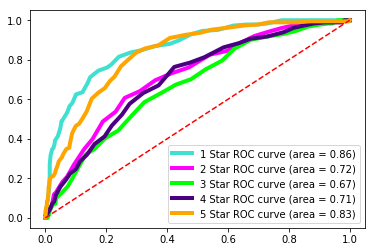

Average AUC =  0.7576609795753692


In [21]:
plot_roc(preds_u)

For the random forest we used 100 trees, which gave us better accuracy than our initial tries with the default parameters, however the random forest was still our weakest model, as can be seen from its ROC curves.

### Linear Support Vector Machine

In [22]:
svm = LinearSVC(random_state = 37)
fit = svm.fit(X_train, y_train)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.4204909284951974


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.53      0.64      0.58       184
          2       0.40      0.28      0.33       201
          3       0.32      0.32      0.32       181
          4       0.34      0.35      0.34       182
          5       0.49      0.52      0.50       189

avg / total       0.41      0.42      0.41       937



 Confusion Matrix: 
 [[117  36  20   5   6]
 [ 70  56  54  14   7]
 [ 16  29  58  50  28]
 [ 10  10  34  64  64]
 [  7  10  15  58  99]]


In [23]:
preds_prob = fit.decision_function(X_test)
preds_u = [0] * 5
for i in range(0, 5):
    preds_u[i] = preds_prob[:, i]

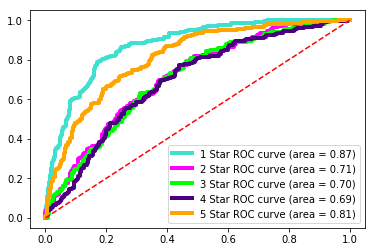

Average AUC =  0.7580243271548867


In [24]:
plot_roc(preds_u)

Our accuracy ranged from .4204909284951974 to .46744930629669157. While on its face this might not seem like a good result, we 
can keep in mind that it is more than twice as good as random guessing, and our ROC plots and their respective AUCs indicate that our
models actually perform reasonably well.

### Oversampling

Here we are taking the TF-IDF matrix created from the entire unbalanced corpus and using the SMOTE algorithm to oversample the data.
SMOTE stands for Synthetic Minority Oversampling Technique, and it works by synthetically generating new values in the minority classes between
the existing values.

In [25]:
tfidf_features,feature_names = tf_idf(review_corpus)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, reviews.iloc[:,3], random_state = 37)
sm = SMOTE(random_state = 37)
smoX, smoy = sm.fit_sample(X_train, y_train)

### Multinomial Naïve Bayes

In [26]:
fit = nb.fit(smoX, smoy)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.4576


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.41      0.57      0.47       189
          2       0.32      0.41      0.36       270
          3       0.31      0.44      0.36       372
          4       0.49      0.52      0.51       861
          5       0.68      0.40      0.50       808

avg / total       0.50      0.46      0.46      2500



 Confusion Matrix: 
 [[107  55  20   5   2]
 [ 64 110  70  20   6]
 [ 23  72 162  99  16]
 [ 36  72 179 445 129]
 [ 34  37  87 330 320]]


In [27]:
preds_prob = fit.predict_proba(X_test)
preds_o = [0] * 5
for i in range(0, 5):
    preds_o[i] = preds_prob[:, i]

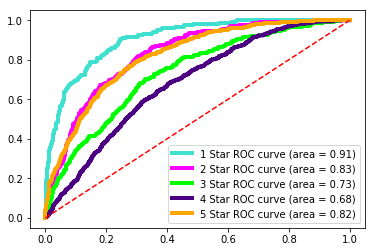

Average AUC =  0.7934910233124023


In [28]:
plot_roc(preds_o)

### Multinomial Logistic Regression

In [29]:
fit = lg.fit(smoX, smoy)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.5084


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.45      0.62      0.52       189
          2       0.38      0.34      0.36       270
          3       0.37      0.37      0.37       372
          4       0.53      0.45      0.49       861
          5       0.60      0.66      0.63       808

avg / total       0.51      0.51      0.50      2500



 Confusion Matrix: 
 [[117  35  18  11   8]
 [ 70  91  65  26  18]
 [ 28  47 138 110  49]
 [ 23  46 120 389 283]
 [ 24  18  37 193 536]]


In [30]:
preds_prob = fit.predict_proba(X_test)
preds_o = [0] * 5
for i in range(0, 5):
    preds_o[i] = preds_prob[:, i]

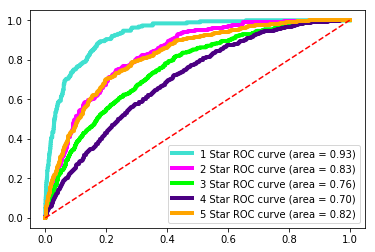

Average AUC =  0.8085147425855863


In [31]:
plot_roc(preds_o)

### Random Forest

In [32]:
fit = rf.fit(smoX, smoy)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.478


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.57      0.45      0.50       189
          2       0.43      0.12      0.19       270
          3       0.35      0.22      0.27       372
          4       0.45      0.53      0.49       861
          5       0.53      0.67      0.59       808

avg / total       0.47      0.48      0.46      2500



 Confusion Matrix: 
 [[ 85   7  14  43  40]
 [ 36  32  43 101  58]
 [ 10  17  80 189  76]
 [ 11   9  71 457 313]
 [  8  10  19 230 541]]


In [33]:
preds_prob = fit.predict_proba(X_test)
preds_o = [0] * 5
for i in range(0, 5):
    preds_o[i] = preds_prob[:, i]

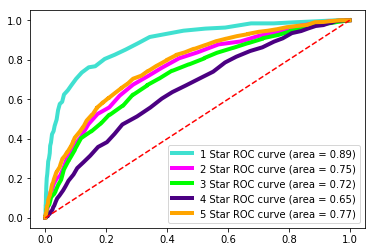

Average AUC =  0.758254265403185


In [34]:
plot_roc(preds_o)

### Linear Support Vector Machine

In [35]:
fit = svm.fit(smoX, smoy)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.478


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.46      0.51      0.48       189
          2       0.37      0.30      0.33       270
          3       0.33      0.33      0.33       372
          4       0.49      0.47      0.48       861
          5       0.55      0.61      0.58       808

avg / total       0.47      0.48      0.47      2500



 Confusion Matrix: 
 [[ 96  35  23  13  22]
 [ 67  80  65  38  20]
 [ 20  35 121 122  74]
 [ 14  44 115 406 282]
 [ 13  20  39 244 492]]


In [36]:
preds_prob = fit.decision_function(X_test)
preds_o = [0] * 5
for i in range(0, 5):
    preds_o[i] = preds_prob[:, i]

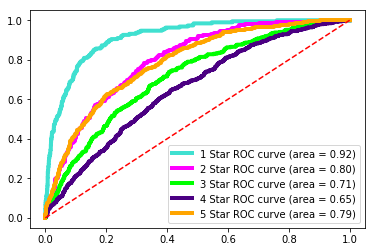

Average AUC =  0.7735592954239418


In [37]:
plot_roc(preds_o)

For the oversampling set of methods, it appears that the AUC for 2-star ratings and 5-star ratings are noticeably closer, with 
that of 2-star ratings even overtaking that of 5-star ratings for some methods. In the metrics reports, you can see that the supports are unbalanced, which is because we did not want to add simlulated values to our test set. The oversampled data was generated based on the original unbalanced corpus, after we had split it into a training and test set. This could possibly be the reason for the decline in AUC of the 5-star ratings with our oversampled data.

The accuracy ranges from .4576 to .5028. This is similar to that of the undersampled data, but slightly better, which is generally
to be expected with oversampled data because our models are given more information. With oversampled data, there is a risk of 
overfitting, but this did not affect us in our case.